In [7]:
import os
import torch
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torchvision import transforms, datasets
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import random_split, Dataset, DataLoader


# config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 256
batch_size = 64
num_epochs = 15
lr = 1e-3

# transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])


# custom dataset for test images
class TestDataset(Dataset):
    def __init__(self, img_dir, label_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        df = pd.read_csv(label_path)
        df = df[df['label'] != -1]
        self.samples = df.reset_index(drop=True)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename = self.samples.loc[idx, 'filename']
        label = int(self.samples.loc[idx, 'label'])
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, filename


In [8]:

# autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# training autoencoder
train_dataset = datasets.ImageFolder(
    root='train_masked_faces',
    transform=transform
)




# split the dataset into training and validation sets
total_size = len(train_dataset)
val_size = int(0.2 * total_size) # 20% for validation
train_size = total_size - val_size # 80% for training
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# model, optimizer, loss and AMP scaler
model = Autoencoder().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scaler = GradScaler()


# early stopping parameters
best_val_loss = float('inf')
patience = 5
counter = 0

# training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, imgs)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            with autocast(): 
                outputs = model(imgs)
                loss = criterion(outputs, imgs)
                val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # early stopping control
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_autoencoder.pth')
        print("The best model is saved.")
    else:
        counter += 1
        print(f"No update. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopped.")
            break


# test and ROC AUC calculation
test_dataset = TestDataset('test_images', 'test_labels.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

recon_errors = []
gt_labels = []

with torch.no_grad():
    for img, label, fname in tqdm(test_loader):
        img = img.to(device)
        recon = model(img)
        error = torch.mean((img - recon) ** 2).item()
        recon_errors.append(error)
        gt_labels.append(label.item())

# ROC-AUC
roc_auc = roc_auc_score(gt_labels, [-e for e in recon_errors])
print(f"ROC-AUC Score: {roc_auc:.4f}")

C:\Users\oztun\AppData\Local\Temp\ipykernel_18908\857308404.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\oztun\AppData\Local\Temp\ipykernel_18908\857308404.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\oztun\AppData\Local\Temp\ipykernel_18908\857308404.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss = 0.0215, Val Loss = 0.0084
The best model is saved.
Epoch 2: Train Loss = 0.0052, Val Loss = 0.0039
The best model is saved.
Epoch 3: Train Loss = 0.0038, Val Loss = 0.0035
The best model is saved.
Epoch 4: Train Loss = 0.0034, Val Loss = 0.0035
No update. Patience counter: 1/5
Epoch 5: Train Loss = 0.0030, Val Loss = 0.0030
The best model is saved.
Epoch 6: Train Loss = 0.0029, Val Loss = 0.0029
The best model is saved.
Epoch 7: Train Loss = 0.0027, Val Loss = 0.0026
The best model is saved.
Epoch 8: Train Loss = 0.0026, Val Loss = 0.0024
The best model is saved.
Epoch 9: Train Loss = 0.0024, Val Loss = 0.0023
The best model is saved.
Epoch 10: Train Loss = 0.0021, Val Loss = 0.0018
The best model is saved.
Epoch 11: Train Loss = 0.0016, Val Loss = 0.0016
The best model is saved.
Epoch 12: Train Loss = 0.0015, Val Loss = 0.0014
The best model is saved.
Epoch 13: Train Loss = 0.0015, Val Loss = 0.0014
The best model is saved.
Epoch 14: Train Loss = 0.0014, Val Loss

100%|██████████| 4356/4356 [00:19<00:00, 219.53it/s]

ROC-AUC Score: 0.8918


In [9]:
# load the best model for testing
model = Autoencoder().to(device)
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()

# test dataset and dataloader
test_dataset = TestDataset('test_images', 'test_labels.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# reconstruction error and ROC AUC
recon_errors = []
gt_labels = []

for imgs, _ in train_loader:
        imgs = imgs.to(device)

with torch.no_grad():
    for img, label, filename in tqdm(test_loader):
        img = img.to(device)
        recon = model(img)
        error = torch.mean((img - recon) ** 2).item()
        recon_errors.append(error)
        gt_labels.append(label.item())
roc_auc = roc_auc_score(gt_labels, [-e for e in recon_errors])
print(f"ROC-AUC Score: {roc_auc:.4f}")


C:\Users\oztun\AppData\Local\Temp\ipykernel_18908\2016675176.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_autoencoder.pth'))
10

ROC-AUC Score: 0.8943


In [12]:
results = []

with torch.no_grad():
    for img, label, fname in tqdm(test_loader):
        img = img.to(device)
        recon = model(img)
        error = torch.mean((img - recon) ** 2).item()
        results.append({
            "filename": fname[0],
            "true_label": int(label.item()),
            "reconstruction_error": error
        })


results_df = pd.DataFrame(results)
results_df.head()

threshold = results_df['reconstruction_error'].quantile(0.75)
results_df['predicted_label'] = (results_df['reconstruction_error'] < threshold).astype(int)

wrong_preds = results_df[results_df['predicted_label'] != results_df['true_label']]
print("Wrong classified images:")
print(wrong_preds[['filename', 'true_label', 'predicted_label']])
wrong_preds = wrong_preds[['filename', 'true_label', 'predicted_label']]
wrong_preds.to_csv("reconstruction_results.csv", index=False)


100%|██████████| 4356/4356 [00:43<00:00, 99.61it/s] 


Wrong classified images:
               filename  true_label  predicted_label
1     test_00000003.jpg           0                1
5     test_00000008.jpg           0                1
45    test_00000058.jpg           1                0
50    test_00000065.jpg           1                0
61    test_00000079.jpg           1                0
...                 ...         ...              ...
4274  test_00004853.jpg           1                0
4276  test_00004855.jpg           1                0
4283  test_00004862.jpg           1                0
4310  test_00004890.jpg           1                0
4341  test_00004921.jpg           0                1

[533 rows x 3 columns]


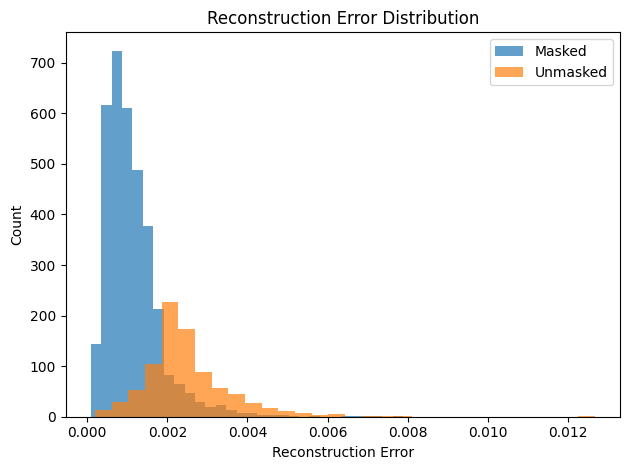

In [13]:

# assumed: recon_errors, gt_labels (1=masked, 0=unmasked)

masked_errors = [e for e, l in zip(recon_errors, gt_labels) if l == 1]
unmasked_errors = [e for e, l in zip(recon_errors, gt_labels) if l == 0]

plt.hist(masked_errors, bins=30, alpha=0.7, label='Masked')
plt.hist(unmasked_errors, bins=30, alpha=0.7, label='Unmasked')
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.tight_layout()
plt.savefig("example_recon_errors.png")
plt.show()
